In [127]:
%reset -f

# Procesamiento de lenguaje natural -I
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Crear un modelo que aprenda a predecir el siguiente carácter en una secuencia de texto, Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia.

In [128]:
import os
import random
import io
import numpy as np
from sklearn.model_selection import train_test_split



### Datos
Utilizaremos como dataset obras literarias que se encuentran en https://www.textos.info/

In [129]:
# descargar de textos.info
import urllib.request
# Para leer y parsear el texto en HTML tipo wikipedia
import bs4 as bs

url_literatura='https://www.textos.info/sun-tzu/el-arte-de-la-guerra/ebook'
raw_html = urllib.request.urlopen(url_literatura)
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
#Usa BeautifulSoup para extraer el texto limpio del HTML
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()
# en la variable article_text almacenamos todo el texto recopilado para el entrenamiento.

print (f'vemos parte del web scraping realizado \n') 
article_text[:500]

vemos parte del web scraping realizado 



' sun tzu dice: la guerra es de vital importancia para el estado;\r\nes el dominio de la vida o de la muerte, el camino hacia la\r\nsupervivencia o la pérdida del imperio: es forzoso manejarla bien.\r\nno reflexionar seriamente sobre todo lo que le concierne es dar\r\nprueba de una culpable indiferencia en lo que respecta a la\r\nconservación o pérdida de lo que nos es mas querido; y ello no debe\r\nocurrir entre nosotros. hay que valorarla en términos de cinco factores fundamentales, y\r\nhacer comparaciones '

In [130]:
## testing scraping multiples textos. 
#import urllib.request
#import bs4 as bs
#import time
#
## 1. Creamos una lista con todas las URLs que queremos procesar
#urls_literatura = [
#    'https://www.textos.info/sun-tzu/el-arte-de-la-guerra/ebook',
#    'https://philodive.com/es/blog/the-art-of-war--a-philosophical-analysis',
#    'https://recursosparapymes.com/arte-de-la-guerra/',
#    'https://www.ruletarusa.mx/historiasrr/el-arte-de-la-guerra-en-el-siglo-xxi/',
#    'https://www.culturagenial.com/es/libro-el-arte-de-la-guerra-de-sun-tzu/'
#]
#
## 2. Inicializamos una variable para almacenar todo el texto combinado
#article_text = ''
## 3. Recorremos la lista de URLs con un bucle 'for'
#for url in urls_literatura:
#    try:
#        time.sleep(1)  # 1 segundo entre requests
#        # 4. Hacemos la solicitud a cada URL
#        raw_html = urllib.request.urlopen(url).read()
#
#        # 5. Usamos BeautifulSoup para analizar el HTML
#        article_html = bs.BeautifulSoup(raw_html, 'lxml')
#
#        # 6. Encontramos todos los párrafos de la página
#        article_paragraphs = article_html.find_all('p')
#
#        # 7. Concatenamos el texto de cada párrafo a nuestra variable principal
#        for para in article_paragraphs:
#            article_text += para.text + ' '
#            
#    except Exception as e:
#        # 8. Manejo de errores en caso de que una URL falle
#        print(f"Error al procesar la URL {url}: {e}")
#
## 9. Convertimos todo el texto a minúsculas, una vez que hemos terminado con todas las URLs
#article_text = article_text.lower()
#
## Opcional: Imprime las primeras 500 letras para verificar que funciona
#print(article_text[:500])
#
#""" 
## scraping web # Implementación: robusta  testing  
## agregar atributo de títulos títulos --> h
## ver como diferenciar publicidad 
#article_text = ''
#exitosas = 0
## Mostrar progreso
#for i, url in enumerate(urls_literatura, 1):
#    try:
#        print(f" Procesando {i}/{len(urls_literatura)}: {url[:50]}...")
#        
#        time.sleep(1)  # 1 segundo entre requests
#        raw_html = urllib.request.urlopen(url).read()
#        article_html = bs.BeautifulSoup(raw_html, 'lxml')
#        article_paragraphs = article_html.find_all('p')
#        
#        parrafos_agregados = 0
#        # Filtrar párrafos vacíos
#        for para in article_paragraphs:
#            texto_para = para.text.strip() # # ayuda a filtrar por número de PALABRAS
#            if len(texto_para) > 10:  # rechazamos párrafo menos de 10 palabras . 
#                article_text += texto_para + ' '
#                parrafos_agregados += 1
#        
#        print(f"Éxito: {parrafos_agregados} párrafos extraídos")
#        exitosas += 1
#        
#    except Exception as e:
#        print(f" Error en {url}: {e}")
#
#article_text = article_text.lower()
#
#print(f"   URLs exitosas: {exitosas}/{len(urls_literatura)}")
#print(f"   Palabras totales: {len(article_text.split()):,}")
#print(f"   Caracteres: {len(article_text):,}")
#print(article_text[:500])
#
#"""

### Elección del Tamaño del Contexto

Aunque todo el corpus de "El Arte de la Guerra" se trata como un único y largo documento, para entrenar el modelo necesitamos dividirlo en secuencias de una longitud fija. en el `max_context_size = 100` definimos un tamaño de contexto ne **caracteres**. Esto significa que cada muestra de entrenamiento que alimentará a la red neuronal consistirá en una secuencia de 100 caracteres, a partir de la cual el modelo aprenderá a predecir 


In [131]:
# seleccionamos el tamaño de contexto en cantidad de caracteres.
max_context_size = 100

Por medio de la función `set` nativa de python creamos un conjunto de caracteres únicos eliminando cualquier duplicidad, aplicamos dicha función al corpus completo de nuestro dataset `article_text` obteniendo un resultado similar al siguiente eje. :  

"arte de la guerra" ->  `set(article_text)` -> **{'a', 'r', 't', 'e', ' ', 'd', '', 'l', '', 'g', 'u', '', ' ', ''}**

**Por qué es fundamental ?**

En un _modelo de lenguaje a nivel de carácter_, el vocabulario no son palabras, sino todos los caracteres posibles que el modelo puede ver o predecir. Esta línea de código es la forma más eficiente de: 
- Identificar el Vocabulario: Descubrir todos los caracteres únicos (letras, números, signos de puntuación, espacios, saltos de línea, etc.) que conforman tu corpus.
- Preparar la Tokenización: Este conjunto chars_vocab es el primer paso para poder convertir el texto en números, un proceso que se realiza justo después al crear los diccionarios char2idx (carácter a índice) y idx2char (índice a carácter).

In [132]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto 
chars_vocab = set(article_text)

In [133]:
# la longitud de vocabulario de caracteres
print (f' la longitud de vocabulario de caracteres es: {len(chars_vocab)}')

 la longitud de vocabulario de caracteres es: 56


**Paso previo antes de tokenizar**
Construimos los dicionarios que asignan índices a caracteres y viceversa. El diccionario `char2idx` servirá como tokenizador.

¿Qué hacen? `char2idx` y `idx2char`

- `char2idx`: Crea un diccionario que asigna a cada carácter único del texto un número (índice). Por ejemplo:

'a' → 0
'b' → 1
' ' → 2
etc.
- `idx2char`: Crea el diccionario inverso, que convierte números de vuelta a caracteres:

0 → 'a'
1 → 'b'
2 → ' '
etc.
Estos diccionarios son esenciales porque las redes neuronales trabajan con números, no con text

In [134]:
# char2idx: mapea cada carácter único a un número (índice) - usado para tokenización
char2idx = {k: v for v,k in enumerate(chars_vocab)}  # Asigna un índice numérico a cada carácter
# idx2char: mapea cada índice de vuelta a su carácter correspondiente - usado para decodificación
idx2char = {v: k for k,v in char2idx.items()}        # Crea el mapeo inverso: índice -> carácter


###  Tokenizar

Tokenización es el proceso conversión de cada carácter → número, también lo podemos definir como la division de un texto en unidades más pequeñas llamadas tokens. El objetivo es convertir el texto, que las máquinas no entienden, en una secuencia de números que sí pueden procesar. El resultado final `tokenized_text` que contiene una larga lista de números que la red neuronal puede utilizar para aprender.

In [135]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [136]:
# Contenido de la variable
tokenized_text[:1000]

[21,
 9,
 23,
 46,
 21,
 7,
 27,
 23,
 21,
 22,
 1,
 10,
 50,
 51,
 21,
 38,
 30,
 21,
 28,
 23,
 50,
 44,
 44,
 30,
 21,
 50,
 9,
 21,
 22,
 50,
 21,
 3,
 1,
 7,
 30,
 38,
 21,
 1,
 41,
 11,
 54,
 44,
 7,
 30,
 46,
 10,
 1,
 30,
 21,
 11,
 30,
 44,
 30,
 21,
 50,
 38,
 21,
 50,
 9,
 7,
 30,
 22,
 54,
 24,
 43,
 15,
 50,
 9,
 21,
 50,
 38,
 21,
 22,
 54,
 41,
 1,
 46,
 1,
 54,
 21,
 22,
 50,
 21,
 38,
 30,
 21,
 3,
 1,
 22,
 30,
 21,
 54,
 21,
 22,
 50,
 21,
 38,
 30,
 21,
 41,
 23,
 50,
 44,
 7,
 50,
 40,
 21,
 50,
 38,
 21,
 10,
 30,
 41,
 1,
 46,
 54,
 21,
 14,
 30,
 10,
 1,
 30,
 21,
 38,
 30,
 43,
 15,
 9,
 23,
 11,
 50,
 44,
 3,
 1,
 3,
 50,
 46,
 10,
 1,
 30,
 21,
 54,
 21,
 38,
 30,
 21,
 11,
 34,
 44,
 22,
 1,
 22,
 30,
 21,
 22,
 50,
 38,
 21,
 1,
 41,
 11,
 50,
 44,
 1,
 54,
 51,
 21,
 50,
 9,
 21,
 26,
 54,
 44,
 27,
 54,
 9,
 54,
 21,
 41,
 30,
 46,
 50,
 12,
 30,
 44,
 38,
 30,
 21,
 35,
 1,
 50,
 46,
 47,
 43,
 15,
 46,
 54,
 21,
 44,
 50,
 26,
 38,
 50,
 55,
 1,
 54,
 4

### Organizando y estructurando el dataset


In [137]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1 # define que el 10% será para validación
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [138]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
# train_text contiene el 90% del texto tokenizado (todo excepto la parte final)
train_text = tokenized_text[:-num_val*max_context_size]
#  contiene el 10% final del texto tokenizado
val_text = tokenized_text[-num_val*max_context_size:]

In [139]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [140]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [ ]:
#Cada secuencia se desplaza un carácter respecto a la anterior
# X: Secuencias de entrada (caracteres 0 a n-1)
# y: Secuencias objetivo (caracteres 1 a n) - desfasadas en 1 posición
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [142]:
X.shape

(77349, 100)

In [143]:
X[0,:10]

array([21,  9, 23, 46, 21,  7, 27, 23, 21, 22])

In [144]:
y[0,:10]

array([ 9, 23, 46, 21,  7, 27, 23, 21, 22,  1])

In [145]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [146]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, LSTM, GRU, Dense
from keras.models import Model, Sequential
from tensorflow import keras
from tensorflow.keras import layers
#from keras.utils import to_categorical
from keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import pickle


El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.


Arquitectura básica de los modelos : Red neuronal recurrente con SimpleRNN , LSTM, GRU
- TimeDistributed + CategoryEncoding: Convierte índices a vectores one-hot a lo largo de la secuencia
- SimpleRNN(200): Capa recurrente con 200 neuronas ocultas
- return_sequences=True: Devuelve secuencias completas (many-to-many)
- dropout=0.1: Regularización para evitar overfitting
- Dense (vocab_size, activation='softmax'): Capa de salida que predice probabilidades para cada carácter del vocabulario

In [147]:
# Red neuronal recurrente con SimpleRNN

# 1. model -> model_simplernn
model_simplernn = Sequential()
# 2. Capa de encoding one-hot para caracteres   (primera línea - CategoryEncoding con output_mode="one_hot")
model_simplernn.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
# 3. 200 unidades ocultas con dropout  (segunda línea - SimpleRNN(200, dropout=0.1, recurrent_dropout=0.1))
model_simplernn.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
# 4. Salida softmax sobre todo el vocabulario
model_simplernn.add(Dense(vocab_size, activation='softmax'))
# 5. optimizer='rmsprop'  objetivo es encontrar los pesos que minimicen la función de pérdida, 
#.. #loss='sparse_categorical_crossentropy' Función de Pérdida métrica que mide qué tan "equivocadas" están las predicciones del modelo en comparación con los valores reales
model_simplernn.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
# 6. mostramos información del modelo. 
model_simplernn.summary()

c:\Users\SAN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_7              │ (None, None, 56)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, None, 200)      │        51,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, None, 56)       │        11,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,656 (244.75 KB)

 Trainable params: 62,656 (244.75 KB)

 Non-trainable params: 0 (0.00 B)

In [148]:
# Modelo LSTM
model_lstm = Sequential()
model_lstm.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None,1)))
model_lstm.add(LSTM(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_lstm.add(Dense(vocab_size, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_lstm.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_8              │ (None, None, 56)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, None, 200)      │       205,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, None, 56)       │        11,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 216,856 (847.09 KB)

 Trainable params: 216,856 (847.09 KB)

 Non-trainable params: 0 (0.00 B)

In [149]:
# Modelo GRU
model_gru = Sequential()
model_gru.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None,1)))
model_gru.add(GRU(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))
model_gru.add(Dense(vocab_size, activation='softmax'))
model_gru.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
model_gru.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_9              │ (None, None, 56)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, None, 200)      │       154,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 56)       │        11,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,056 (648.66 KB)

 Trainable params: 166,056 (648.66 KB)

 Non-trainable params: 0 (0.00 B)

### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

Callback Personalizado (PplCallback)
- Primero se define una clase especial que monitorea el entrenamiento:
- `class PplCallback(keras.callbacks.Callback):`

¿Qué hace este callback?
- Calcula perplejidad: Métrica que mide qué tan "sorprendido" está el modelo con los datos de validación
    - Perplejidad baja = modelo predice bien
    - Perplejidad alta = modelo está confundido
- Early Stopping: Detiene el entrenamiento automáticamente si no mejora
    - patience=5: espera 5 épocas sin mejora antes de parar
    - - Evita sobreentrenamiento (overfitting)
- Guarda el mejor modelo: Cuando encuentra una perplejidad menor, guarda el modelo en "my_model.keras"

In [150]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    # model_name lo utilizamos para distinguir los modelos  "simplernn_model", "lstm_model", "gru_model"
    def __init__(self, val_data, history_ppl, model_name="my_model", patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.model_name = model_name 
      self.history_ppl = history_ppl

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(f"{self.model_name}.keras")
          print(f"Saved new model {self.model_name}")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento (Proceso del entrenamiento)

Parámetros explicados:
- X, y: Datos de entrada y salida (secuencias desplazadas)
- epochs=20: Máximo 20 pasadas completas por todos los datos
- batch_size=256: Procesa 256 secuencias a la vez (más eficiente)
- callbacks=[PplCallback(...)]: Usa el callback personalizado

Flujo durante cada época:
- Entrenamiento: El modelo aprende con los datos de entrenamiento
- Validación: Al final de cada época, el callback:
    - Calcula perplejidad en datos de validación
    - Compara con la mejor perplejidad anterior
    - Si mejora → guarda modelo y resetea contador de paciencia
    - Si no mejora → incrementa contador de paciencia
    - Si contador llega a 5 → detiene entrenamient

In [151]:
# Guardado del modelo 
# Definir rutas y Guardado para los tres modelos
model_paths = {
    'simplernn': 'simplernn_model.keras',
    'lstm': 'lstm_model.keras', 
    'gru': 'gru_model.keras'
}

history_paths = {
    'simplernn': 'history_simplernn.pkl',
    'lstm': 'history_lstm.pkl',
    'gru': 'history_gru.pkl'
}

# guardarán los valores de perplejidad para cada época.
# Listas de historial separadas
history_ppl_simplernn = []
history_ppl_lstm = []
history_ppl_gru = []

# Diccionario de modelos
models = {
    'simplernn': model_simplernn,
    'lstm': model_lstm,
    'gru': model_gru
}

# Diccionario de historiales
histories = {
    'simplernn': history_ppl_simplernn,
    'lstm': history_ppl_lstm,
    'gru': history_ppl_gru
}
hist = None

# Entrenar cada modelo
for model_name in ['simplernn', 'lstm', 'gru']:
    print(f"\n=== Entrenando modelo {model_name.upper()} ===")
    
    model_path = model_paths[model_name]
    history_path = history_paths[model_name]
    current_model = models[model_name]
    current_history = histories[model_name]
    
    if os.path.exists(model_path):
        print(f"El modelo {model_name} ya existe, cargando historial...")
        if os.path.exists(history_path):
            with open(history_path, 'rb') as f:
                current_history.extend(pickle.load(f))
    else:
        print(f"Entrenando modelo {model_name}...")
        hist = current_model.fit(X, y, epochs=20,
                                callbacks=[PplCallback(tokenized_sentences_val, current_history, f"{model_name}_model")],
                                batch_size=256)
                                #callbacks=[PplCallback(tokenized_sentences_val, current_history, model_name)], 
        
        # Guardar historial
        with open(history_path, 'wb') as f:
            pickle.dump(current_history, f)




=== Entrenando modelo SIMPLERNN ===
El modelo simplernn ya existe, cargando historial...

=== Entrenando modelo LSTM ===
El modelo lstm ya existe, cargando historial...

=== Entrenando modelo GRU ===
El modelo gru ya existe, cargando historial...


#### Gráfica que muestra cómo evoluciona la perplejidad:
- Eje X: Número de época
- Eje Y: Valor de perplejidad
- Tendencia esperada: Línea descendente (perplejidad mejorando)
- perplejidad: Métrica más interpretable que la loss function para modelos de lenguaje
- Encontrar cuál tuvo la menor perplejidad final (menor perplejidad = mejor)

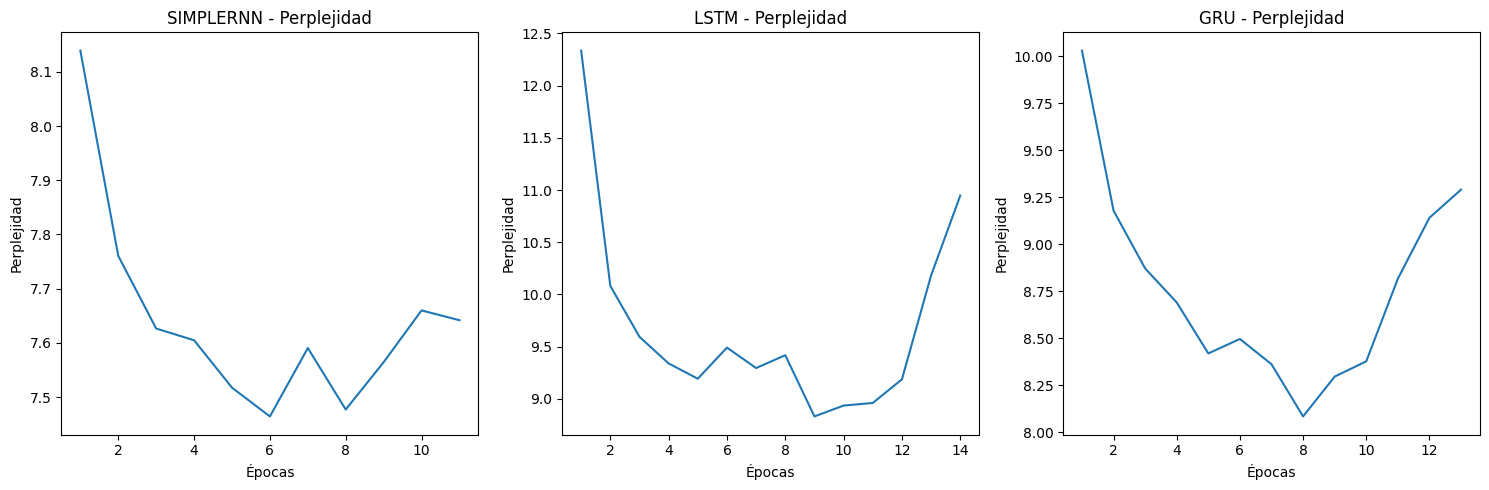

In [152]:
# Gráfica comparativa de entrenamiento 
import matplotlib.pyplot as plt
#import seaborn as sns

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfica para cada modelo
for i, model_name in enumerate(['simplernn', 'lstm', 'gru']):
    current_history = histories[model_name]
    if len(current_history) > 0:
        epoch_count = range(1, len(current_history) + 1)
        axes[i].plot(epoch_count, current_history)
        axes[i].set_title(f'{model_name.upper()} - Perplejidad')
        axes[i].set_xlabel('Épocas')
        axes[i].set_ylabel('Perplejidad')

plt.tight_layout()
plt.show()

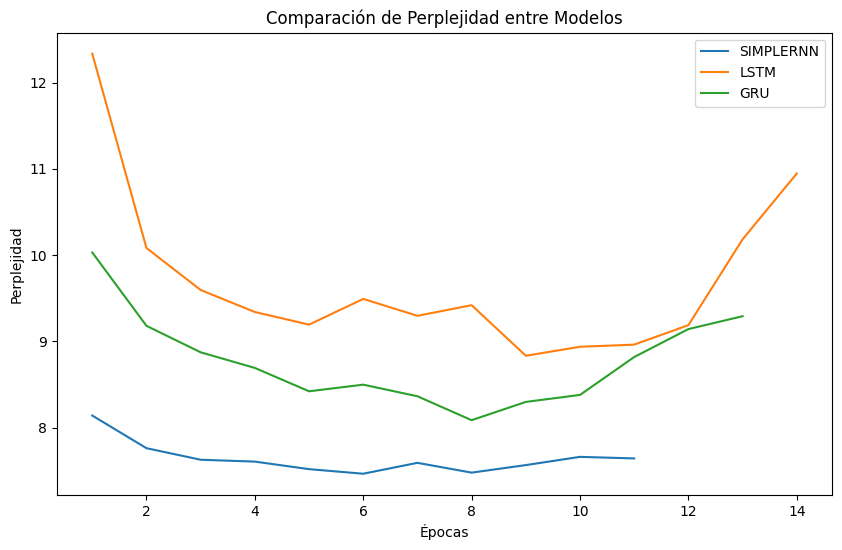

In [153]:
# Una sola gráfica con las tres curvas
plt.figure(figsize=(10, 6))

for model_name in ['simplernn', 'lstm', 'gru']:
    current_history = histories[model_name]
    if len(current_history) > 0:
        epoch_count = range(1, len(current_history) + 1)
        plt.plot(epoch_count, current_history, label=model_name.upper())

plt.xlabel('Épocas')
plt.ylabel('Perplejidad')
plt.title('Comparación de Perplejidad entre Modelos')
plt.legend()
plt.show()

In [154]:
#  análisis del rendimiento en el entrenamiento del los modelos

""" 
ver donde colocar mejor ? 
Caso 1: se realiza entrenamiento 
    Las listas contienen los valores de perplejidad de cada época del entrenamiento 
    Fuente: Directamente del entrenamiento reciente cargado en memoria 

Caso 2: Si se carga modelos pre-entrenados
    la info se carga desde los archivos .pkl cargado el modelo en memoria 
    Fuente: history_simplernn.pkl, history_lstm.pkl, history_gru.pkl
"""
print("\n" + "="*50)
print(" -- RESUMEN DE RENDIMIENTO POR MODELO ---")

best_overall_model = None
best_overall_perplexity = float('inf')

for model_name in ['simplernn', 'lstm', 'gru']:
    current_history = histories[model_name] # ← modelos cargados en MEMORIA
    
    if len(current_history) > 0:
        # Perplejidad inicial y final
        initial_perplexity = current_history[0]
        final_perplexity = current_history[-1]
        total_epochs = len(current_history)
        improvement = initial_perplexity - final_perplexity
        
        print(f"\n- {model_name.upper()}:")
        print(f"   • Épocas entrenadas: {total_epochs}")
        print(f"   • Perplejidad inicial: {initial_perplexity:.4f}")
        print(f"   • Perplejidad final: {final_perplexity:.4f}")
        print(f"   • Mejora total: {improvement:.4f}")
        
        # Tracking del mejor modelo general
        if final_perplexity < best_overall_perplexity:
            best_overall_perplexity = final_perplexity
            best_overall_model = model_name
            
    else:
        print(f"\n- {model_name.upper()}: Sin historial de entrenamiento")

# Mostrar el ganador
if best_overall_model:
    print(f"\n MEJOR MODELO GENERAL: {best_overall_model.upper()}")
    print(f" Mejor perplejidad alcanzada: {best_overall_perplexity:.4f}")

print("="*50)


 -- RESUMEN DE RENDIMIENTO POR MODELO ---

- SIMPLERNN:
   • Épocas entrenadas: 11
   • Perplejidad inicial: 8.1391
   • Perplejidad final: 7.6419
   • Mejora total: 0.4973

- LSTM:
   • Épocas entrenadas: 14
   • Perplejidad inicial: 12.3345
   • Perplejidad final: 10.9461
   • Mejora total: 1.3884

- GRU:
   • Épocas entrenadas: 13
   • Perplejidad inicial: 10.0299
   • Perplejidad final: 9.2908
   • Mejora total: 0.7391

 MEJOR MODELO GENERAL: SIMPLERNN
 Mejor perplejidad alcanzada: 7.6419


### Carga los 3 modelos (simplernn, lstm, gru)

Después del entrenamiento, cargamos el mejor modelo de cada uno (simplernn, lstm, gru) no necesariamente el último para hacer predicciones.





In [89]:
# Cargamos los 3 modelos en memoria:
# Cargar los mejores modelos guardados para hacer inferencia
loaded_models = {}

for model_name in ['simplernn', 'lstm', 'gru']:
    model_path = model_paths[model_name]
    if os.path.exists(model_path):
        #se cargan los 3 modelos EN MEMORIA
        loaded_models[model_name] = keras.models.load_model(model_path)
        print(f"Cargado modelo {model_name.upper()} desde {model_path}")
    else:
        print(f" Advertencia: No se encontró el modelo {model_name}")

# Para mantener compatibilidad con el código existente posterior, 
# asignamos uno como modelo por defecto (prioridad: LSTM > SimpleRNN > GRU)
model = loaded_models.get('lstm', loaded_models.get('simplernn', loaded_models.get('gru')))

# bloque no relevante 
if model is None:
    print(" Error: No se pudo cargar ningún modelo entrenado")
else:
    # Mostrar qué modelo se asignó por defecto
    for name, loaded_model in loaded_models.items():
        if loaded_model is model:
            print(f"\n Modelo por defecto asignado: {name.upper()}")
            break

print(f"Total de modelos cargados: {len(loaded_models)}")

# Carga individual del modelo 
#model = keras.models.load_model('simplernn_model.keras')
#model = keras.models.load_model('lstm_model.keras')
#model = keras.models.load_model('gru_model.keras')

Cargado modelo SIMPLERNN desde simplernn_model.keras
Cargado modelo LSTM desde lstm_model.keras
Cargado modelo GRU desde gru_model.keras

 Modelo por defecto asignado: LSTM
Total de modelos cargados: 3


### Predicción del próximo carácter con Gradio
Gradio es una herramienta muy útil para crear interfaces web interactivas que permiten probar modelos de machine learning de forma intuitiva y visual. el objetivo es Predecir el próximo carácter utilizando los modelos entrenados (SimpleRNN, LSTM, GRU) mediante selección determinista del carácter más probable.
 - Entrada: Texto semilla (seed text)
 - Salida: Texto original + 1 carácter nuevo predicho


Funcionamiento:
- Codificación: Convierte el texto de entrada a índices numéricos
- Padding: Ajusta la secuencia al tamaño de contexto requerido (max_context_size)
- Predicción: El modelo genera probabilidades para cada carácter del vocabulario
- Selección: Se elige el carácter con mayor probabilidad (np.argmax)
- Decodificación: Convierte el índice predicho de vuelta a carácter
- Resultado: Retorna el texto original concatenado con el nuevo carácter


In [ ]:
# Predicción del próximo carácter con gradio
# https://gradio.app/
#!pip install -q gradio

import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    ######################y_hat = np.argmax(model.predict(encoded)[0,-1,:])
    y_hat = np.argmax(loaded_models['simplernn'].predict(encoded)[0,-1,:])  # ← SIMPLERNN
    # y_hat = np.argmax(loaded_models['lstm'].predict(encoded)[0,-1,:])     # ← LSTM  
    # y_hat = np.argmax(loaded_models['gru'].predict(encoded)[0,-1,:])      # ← GRU


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word # Solo agrega 1 palabra
#
iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)


### Generación de secuencias `generate_seq`

Generar texto automáticamente extendiendo una frase inicial mediante predicción iterativa de caracteres, utilizando los modelos entrenados (SimpleRNN, LSTM, GRU).

Funcionamiento:
- Entrada: Texto semilla + cantidad de caracteres a generar (n_words=36)
- Proceso: Predicción iterativa carácter por carácter
- Selección: Siempre el carácter más probable en cada iteración
- Salida: Texto original extendido con 36 caracteres nuevos

In [91]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words): # Bucle para múltiples caracteres
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [92]:
# llamada a  def generate_seq(model, seed_text, max_length, n_words):

# Probar con cada modelo individualmente
input_text='disciplina es la clave'

# SimpleRNN
print("=== SIMPLERNN ===")
resultado_simplernn = generate_seq(loaded_models['simplernn'], input_text, max_length=max_context_size, n_words=36)
print(resultado_simplernn)

# LSTM  
print("\n=== LSTM ===")
resultado_lstm = generate_seq(loaded_models['lstm'], input_text, max_length=max_context_size, n_words=36)
print(resultado_lstm)

# GRU
print("\n=== GRU ===") 
resultado_gru = generate_seq(loaded_models['gru'], input_text, max_length=max_context_size, n_words=36)
print(resultado_gru)

=== SIMPLERNN ===
disciplina es la claves a tus tropas son considar sus prop

=== LSTM ===
disciplina es la clavera de la mictoria de la victoria de 

=== GRU ===
disciplina es la clave de la batalla de la batalla de la b


###  Beam search y muestreo aleatorio

Implementar técnicas avanzadas de generación de texto que ofrecen mayor control sobre la creatividad y coherencia del contenido generado, superando las limitaciones del método greedy simple.

 Funcionamiento básico del Beam Search: El algoritmo mantiene múltiples candidatos prometedores (beams) en paralelo durante la generación, evaluando las mejores secuencias posibles en lugar de seleccionar solo la opción más probable en cada paso.

<div style="text-align: right;">
	<h1 style="display: inline-block;margin: 0;padding: 8px 16px;color: white;background: linear-gradient(to right,rgb(17, 75, 141), #4CAF50);border-radius: 12px;font-size: 1.8rem;box-shadow: 0 4px 10px rgba(0, 0, 0, 0.3);">nota</h1>
</div>


`encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')`
Esta línea de código se encarga de preparar una secuencia de texto (ya convertida a números/índices) para que pueda ser procesada por el modelo de red neuronal.

- ad_sequences(...): Es una función de Keras muy útil. Las redes neuronales recurrentes (RNNs) esperan que todas las secuencias de entrada en un lote tengan la misma longitud. Esta función se encarga de que así sea.
- maxlen=max_length: Le dice a la función cuál es la longitud deseada para la secuencia. En tu notebook, es 100.
- padding='pre': Este es el argumento clave. Si una secuencia es más corta que max_length, necesita ser "rellenada" (padded) para alcanzar esa longitud. padding='pre' significa que el relleno (generalmente ceros) se añade al principio (prefijo) de la secuencia.
- Ejemplo: Si max_length es 10 y tu secuencia codificada es [5, 8, 12], el resultado después de esta línea sería: [0, 0, 0, 0, 0, 0, 0, 5, 8, 12]

- pre: Es un tipo de padding (relleno) que se añade al principio de una secuencia para que todas tengan la misma longitud.
- det: Es un modo de selección determinista. Siempre elige las opciones con la puntuación más alta, sin aleatoriedad.
- sto: Es un modo de selección estocástico. Elige las siguientes opciones de forma aleatoria basándose en una distribución de probabilidad, lo que permite generar texto más variado.


Modos de operación **Beam search**:
🔸 Modo Determinista (mode='det'):

Estrategia: Selecciona siempre los num_beams candidatos con mayor probabilidad
Comportamiento: Reproducible - mismo input = mismo output
Uso: Cuando necesitas consistencia y coherencia máxima
Ejemplo: beam_search(model, num_beams=10, mode='det')

🔸 Modo Estocástico (mode='sto'):

Estrategia: Muestreo probabilístico con control de temperatura
Comportamiento: Variable - introduce creatividad controlada
Parámetro temperatura: Controla el balance creatividad/conservadurismo

temp < 1.0: Más conservador, menos creatividad
temp = 1.0: Distribución natural del modelo
temp > 1.0: Más creativo, mayor variabilidad

In [93]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):
    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])



In [ ]:
from scipy.special import softmax
#import random

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):
    #print(f"Info control permer y en cada for hist in history_tokens >>> modelo: {model}, modo: '{mode}', temperatura: {temp}\n") # testing imprime en cada siclo del  # beam search loop del `for hist in history_tokens:`

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'modelo - {mode} -seleccionado  erróneo.   "det" y "sto" son compatibles.')
  # Wrong selection mode {mode} was given. "det" and "sto" are supported.

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)
  ######## prueba para retornar valor 
  ########return pred_large[idx_select.astype(int)], new_history_tokens.astype(int), temp,mode

# temp por default 
def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):
    # {model} indica el nombre asignado al modelos bloques de --Definiendo el modelo--
    print(f"Info control > predict del modelo: {model}, modo estocástico: '{mode}', temperatura: {temp}\n")
    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)
    
    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

En los siguientes ejemplos utilizaremos la función **beam_search** que definimos previamente (arriba) para generar texto nuevo a partir de una frase "disciplina es la clave" y "ventaja sobre los adversarios" que son oraciones relacionadas al contexto del arte de la guerre pero no se encuentran textualmente en el dataset del texto. 

Explicación de los resultados, 
Comando de entrada para la función `salidas = beam_search(model,num_beams=10,num_words=20,input="disciplina es la clave")`

- beam_search(...): Es la función que implementa la generación de texto.
- model: Es tu modelo de red neuronal ya entrenado.
- num_beams=10: Le indicamos la función que use la estrategia Beam Search manteniendo las 10 secuencias más probables en cada paso de la generación. Esto suele dar resultados más coherentes que simplemente elegir la opción más probable cada vez (Greedy Search).
- input=: Esta es el texto referencia que el modelo usará para predecir los siguientes caracteres que conformaran las palabras. 
- num_words=: Le dice al modelo que genere x cantidad de caracteres nuevos después del texto de entrada.
- `salidas[0]`: La variable que almacena el resultado. Contiene un array con las 10 `num_beams=10` secuencias de texto (codificadas como números) que el modelo considera las mejores. La primera (salidas2[0]) es la más probable de todas.
- `decode(salidas[0])`: toma esa secuencia de números más probable y la traduce de nuevo a texto que podemos leer.

In [95]:
# Llama a la función de búsqueda para generar texto con los 3 modelos
input_text = "disciplina es la clave"

print("COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA")  

for model_name in ['simplernn', 'lstm', 'gru']:
    if model_name in loaded_models:
        print(f"\n--- {model_name.upper()} ---")
        
        salidas = beam_search(loaded_models[model_name], num_beams=10, num_words=150, 
                             input=input_text,temp=1, mode='det')
                             #input=input_text,temp=1.2, mode='sto')
                             #input=input_text,temp=0.8,mode='sto')
        
        # Muestra la secuencia de números (índices) más probable que generó el modelo.
        print(f"Secuencia de índices: {salidas[0]}")
        # Convierte la secuencia de números de vuelta a texto legible y la muestra.
        print(f"Texto generado: {decode(salidas[0])}")
        print("-" * 40)
    else:
        print(f"\n Modelo {model_name} no disponible")

# consulta de manera individual 
#salidas = beam_search(loaded_models['simplernn'], num_beams=10, num_words=150, input="disciplina es la clave",temp=1.2, mode='det')
#salidas = beam_search(loaded_models['lstm'], num_beams=10, num_words=150, input=input_text,temp=1.2, mode='det')
#salidas = beam_search(loaded_models['gru'], num_beams=10, num_words=150, input=input_text,temp=1.2, mode='det')



COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA

--- SIMPLERNN ---
Info control > predict del modelo: <Sequential name=sequential, built=True>, modo estocástico: 'det', temperatura: 1

Secuencia de índices: [22  1  9 10  1 11 38  1 46 30 21 50  9 21 38 30 21 10 38 30  3 50  9 21
 22 50 21 38 54  9 21 30 22  3 50 44  9 30 44  1 54  9 21 22 50 21 38 54
  9 21 30 22  3 50 44  9 30 44  1 54  9 21 22 50 21 38 54  9 21 30 22  3
 50 44  9 30 44  1 54  9 21 22 50 21 38 54  9 21 30 22  3 50 44  9 30 44
  1 54  9 21 22 50 21 38 54  9 21 30 22  3 50 44  9 30 44  1 54  9 21 22
 50 21 38 54  9 21 30 22  3 50 44  9 30 44  1 54  9 21 22 50 21 38 54  9
 21 30 22  3 50 44  9 30 44  1 54  9 21 22 50 21 38 54  9 21 30 22  3 50
 44  9 30 44]
Texto generado: disciplina es la claves de los adversarios de los adversarios de los adversarios de los adversarios de los adversarios de los adversarios de los adversarios de los adversar
----------------------------------------

--- LSTM ---
Info control > predict del m

<div style="text-align: right;">
	<h1 style="display: inline-block;margin: 0;padding: 8px 16px;color: white;background: linear-gradient(to right,rgb(17, 75, 141), #4CAF50);border-radius: 12px;font-size: 1.8rem;box-shadow: 0 4px 10px rgba(0, 0, 0, 0.3);">nota</h1>
</div>

Nos preguntamos **¿Por qué el modelo repite las palabras?**

El problema no está como fue entrenado el modelo en sí, sino en la forma en que se genera el texto (la inferencia)a causa del  método de búsqueda llamado Beam Search determinista (mode='det').
- indicamos al modelo que genere un texto a partir de _"disciplina es la clave"_ en cada paso el modelo tiene que elegir el siguiente carácter 
- Resultado : 'disciplina es la claves -- de los adversarios están en un terreno de manera que los soldados en un terreno de manera que los soldados están en un terreno de manera que el enem'

- Greedy Search (Búsqueda Voraz): Elige el carácter más probable en cada paso. Si _"clave"_  la secuencia más probable es _"de los adversarios están"_ , y después de _"de los adversarios están"_ lo más probable es _"en un terreno de manera que los soldados"_, y después de _"en un terreno de manera que los soldados"_ lo más probable es "los soldados", el modelo entra en un bucle sin fin.

- Beam Search Determinista (lo que usas): Es una mejora. En lugar de elegir solo la opción más probable, mantiene un número (num_beams) de las secuencias más probables. Sin embargo, si la secuencia repetitiva ("de la fuerza de la fuerza") es consistentemente la que tiene la probabilidad más alta, el Beam Search la seguirá eligiendo, ya que su objetivo es encontrar la secuencia con la máxima probabilidad total.
- el modelo se queda "atascado" en un bucle de alta probabilidad del que no puede escapar porque no hay aleatoriedad en su decisión, también tomemos en cuenta el dataset del arte de la guerra no es un texto rico en variedad de términos, podríamos considerar aumentar el corpus ejemplo agregando mas libros relacionados al arte de la guerra. 

Probando otras configuraciones para generar mas aleatoriedad en los resultados 
- cambiemos el modo Estocástico (mode='sto'): En lugar de elegir siempre las k mejores secuencias, el modo estocástico las muestra de la distribución de probabilidad. Esto significa que a veces puede elegir una secuencia un poco menos probable, lo que le permite "saltar" fuera de los bucles repetitivos y explorar caminos más creativos.

- Ajuste de la temperatura de nuestro modelos 0.8 < 1 > 1.2 
	- valor menos a 1 ejempló  0.8 hace que nuestro modelo sea mas conservador, las probabilidades de los caracteres más probables se refuerzan y las de los menos probables se reducen. El texto será más coherente pero con menos sorpresa.
	- silo igualamos a  1 como en la generación de texto anterior el modo muestra directamente de la distribución de probabilidad  neutra que el modelo aprendió.
	- es mayor a 1 ejemplo 1.2 aumenta la aleatoriedad. El modelo puede elegir caracteres menos probables con más frecuencia. Esto puede generar texto más interesante y sorprendente, pero también aumenta el riesgo de que no tenga sentido 

In [ ]:
# Llama a la función de búsqueda para generar texto con los 3 modelos
input_text = "disciplina es la clave"

print("COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA")  

for model_name in ['simplernn', 'lstm', 'gru']:
    if model_name in loaded_models:
        print(f"\n--- {model_name.upper()} ---")
        
        salidas = beam_search(loaded_models[model_name], num_beams=10, num_words=150,
                              input=input_text,temp=1.2, mode='sto')
        
        # Muestra la secuencia de números (índices) más probable que generó el modelo.
        #print(f"Secuencia de índices: {salidas[0]}")
        # Convierte la secuencia de números de vuelta a texto legible y la muestra.
        print(f"Texto generado: {decode(salidas[0])}")
        print("-" * 40)
    else:
        print(f"\n Modelo {model_name} no disponible")

COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA

--- SIMPLERNN ---
Info control > predict del modelo: <Sequential name=sequential, built=True>, modo estocástico: 'sto', temperatura: 1.2

Texto generado: disciplina es la claves a tis adversarios son como un terreno de los adversarios son debilidad de la fuerza de los soldados son como el adversarios son debilidad de sus pol
----------------------------------------

--- LSTM ---
Info control > predict del modelo: <Sequential name=sequential_1, built=True>, modo estocástico: 'sto', temperatura: 1.2

Texto generado: disciplina es la clavera de la que el una puede la conera de ataquición de la ventar a los derrenos de la fuerza, está
están cuando están cuando en cuando en manera que el
----------------------------------------

--- GRU ---
Info control > predict del modelo: <Sequential name=sequential_2, built=True>, modo estocástico: 'sto', temperatura: 1.2

Texto generado: disciplina es la clave de las tropas están en la fuerza de las tropas c

In [ ]:
# Llama a la función de búsqueda para generar texto con los 3 modelos
input_text = "disciplina es la clave"

print("COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA")  

for model_name in ['simplernn', 'lstm', 'gru']:
    if model_name in loaded_models:
        print(f"\n--- {model_name.upper()} ---")
        
        salidas = beam_search(loaded_models[model_name], num_beams=10, num_words=150,
                              input=input_text,temp=0.8,mode='sto')
        
        # Muestra la secuencia de números (índices) más probable que generó el modelo.
        #print(f"Secuencia de índices: {salidas[0]}")
        # Convierte la secuencia de números de vuelta a texto legible y la muestra.
        print(f"Texto generado: {decode(salidas[0])}")
        print("-" * 40)
    else:
        print(f"\n Modelo {model_name} no disponible")

COMPARACIÓN BEAM SEARCH - MODO DETERMINISTA

--- SIMPLERNN ---
Info control > predict del modelo: <Sequential name=sequential, built=True>, modo estocástico: 'sto', temperatura: 0.8

Texto generado: disciplina es la claves de manera que los adversarios son combatir por lo tanto, los adversarios de los adversarios son combatir conocer a los adversarios son después de lo
----------------------------------------

--- LSTM ---
Info control > predict del modelo: <Sequential name=sequential_1, built=True>, modo estocástico: 'sto', temperatura: 0.8

Texto generado: disciplina es la claverar a los adversarios de las que estos de compera de los adversarios de las adversarios de las que los adversarios. si están es las puedes de están a 
----------------------------------------

--- GRU ---
Info control > predict del modelo: <Sequential name=sequential_2, built=True>, modo estocástico: 'sto', temperatura: 0.8

Texto generado: disciplina es la claves de las tropas en un terreno de los adversarios